In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade ultralytics --no-deps
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="vM6qrOEJgCQAXNdbbGk0")

project = rf.workspace("objectdetection-tecsf").project("skysealand-wrqjn")
version = project.version(2)

# Correct dataset format
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 106.3 MB/s eta 0:00:0000:01
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 


Extracting Dataset Version Zip to Skysealand-2 in yolov8:: 100%|██████████| 2626/2626 [00:00<00:00, 3589.32it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from ultralytics import YOLO

model = YOLO("yolo12s")  # choose nano version

In [4]:
import os, gc, json, shutil, yaml, warnings, random, math, copy
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from ultralytics import YOLO

In [5]:
import os

print(os.listdir("/kaggle/working"))


['yolo12s.pt', 'Skysealand-2', '.virtual_documents']


In [6]:
for item in os.listdir("/kaggle/working"):
    print(item)


yolo12s.pt
Skysealand-2
.virtual_documents


In [7]:
import os

base = "/kaggle/working"
dataset_dir = [d for d in os.listdir(base) if d.lower().startswith("sky")][0]

print("Dataset folder:", dataset_dir)

yaml_path = f"{base}/{dataset_dir}/data.yaml"

yaml_content = f"""
train: {base}/{dataset_dir}/train/images
val: {base}/{dataset_dir}/valid/images
test: {base}/{dataset_dir}/test/images

nc: 4
names:
  - Airplane
  - Boat
  - Car
  - Ship
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("Data.yaml written to:", yaml_path)


Dataset folder: Skysealand-2
Data.yaml written to: /kaggle/working/Skysealand-2/data.yaml


In [8]:
print(os.listdir(f"/kaggle/working/{dataset_dir}"))


['train', 'test', 'data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'valid']


In [9]:
for root, dirs, files in os.walk("/kaggle/working"):
    if "data.yaml" in files:
        print(os.path.join(root, "data.yaml"))


/kaggle/working/Skysealand-2/data.yaml


In [10]:
import os, shutil

base_path = "/kaggle/working/Skysealand-2"

for folder in ['train', 'valid', 'test']:
    img_dir = os.path.join(base_path, folder, 'images')
    label_dir = os.path.join(base_path, folder, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

# move misplaced images from root into train/images if any
for f in os.listdir(base_path):
    if f.endswith('.jpg') or f.endswith('.png'):
        shutil.move(os.path.join(base_path, f), os.path.join(base_path, 'train/images', f))

print("Folder structure ready for YOLO training.")

Folder structure ready for YOLO training.


In [11]:
import os
os.listdir("/kaggle/working")


['yolo12s.pt', 'Skysealand-2', '.virtual_documents']

In [12]:

from pathlib import Path
import os

# Auto-detect SkySeaLand dataset folder
base = "/kaggle/working"
dataset_dir = [d for d in os.listdir(base) if "sky" in d.lower()][0]

DATA = f"{base}/{dataset_dir}/data.yaml"
OUTPUT_FOLDER = Path("/kaggle/working/yolo-output")

# Check YAML exists before training
if not Path(DATA).exists():
    raise FileNotFoundError(f"data.yaml not found at: {DATA}")

print("Using dataset:", DATA)

# Correct model name (YOLOv8)
model = YOLO("yolov8n.pt")

# Train model
model.train(
    data=DATA,
    epochs=50,
    imgsz=640,
    batch=16,
    workers=2,
    project=str(OUTPUT_FOLDER),
    name="train"
)

print("Training started successfully!")


Using dataset: /kaggle/working/Skysealand-2/data.yaml
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Skysealand-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

invalid value encountered in less
invalid value encountered in less


                   all        132       1992      0.848      0.762      0.819      0.511
              Airplane         37        367      0.953      0.879      0.931      0.548
                  Boat         33        657      0.805      0.738      0.793      0.491
                   Car         31        679      0.863       0.76      0.815      0.528
                  Ship         52        289      0.771      0.671      0.737       0.48
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/yolo-output/train
Training started successfully!


In [13]:
from ultralytics import YOLO
from pathlib import Path

# --- 1. Define Paths ---
# Ensure these paths match your training setup
DATA = "/kaggle/working/Skysealand-2/data.yaml"
OUTPUT_FOLDER = Path("/kaggle/working/yolo-output")
# This assumes your training run was named "train" (from project=OUTPUT_FOLDER, name="train")
# If you used a different name, change "train" here.
TRAIN_RUN_PATH = OUTPUT_FOLDER / "train" 
BEST_WEIGHTS_PATH = TRAIN_RUN_PATH / "weights" / "best.pt"

# --- 2. Load the Best Model ---
# Load the best model weights saved during training
print(f"Loading best model from: {BEST_WEIGHTS_PATH}")
model = YOLO(BEST_WEIGHTS_PATH)

# --- 3. Evaluate on the Test Set ---
print("Evaluating model on the 'test' split...")
metrics = model.val(
    data=str(DATA),
    split="test",
    plots=True,                 # Save confusion matrix, P-R curve, etc.
    project=str(OUTPUT_FOLDER),
    name="test_evaluation"      # Saves results to /kaggle/working/yolo-output/test_evaluation
)

# --- 4. Extract, Calculate, and Print Metrics ---
print("Extracting metrics...")
map50_95 = metrics.box.map    # mAP@0.5:0.95
map50 = metrics.box.map50     # mAP@0.5
precision = metrics.box.mp    # Precision
recall = metrics.box.mr       # Recall

# Calculate F1 Score
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6) # Add 1e-6 to avoid division by zero

# Print the results in a clean format
print("\n--- Test Set Evaluation Results ---")
print(f"Model: {str(BEST_WEIGHTS_PATH)}")
print(f"mAP@0.5:0.95: {map50_95:.4f}")
print(f"mAP@0.5       : {map50:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print("-----------------------------------")

Loading best model from: /kaggle/working/yolo-output/train/weights/best.pt
Evaluating model on the 'test' split...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2411.0±1045.2 MB/s, size: 250.4 KB)
val: Scanning /kaggle/working/Skysealand-2/test/labels... 127 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 127/127 1.2Kit/s 0.1s<0.0s
val: New cache created: /kaggle/working/Skysealand-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.5it/s 3.2s0.2s


invalid value encountered in less
invalid value encountered in less


                   all        127       2075      0.839      0.755      0.833      0.496
              Airplane         52        553      0.944      0.917      0.949      0.534
                  Boat         23        334      0.754      0.719      0.781      0.478
                   Car         24        798      0.834      0.742      0.832      0.508
                  Ship         46        390      0.825      0.641      0.772      0.463
Speed: 1.5ms preprocess, 8.4ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to /kaggle/working/yolo-output/test_evaluation
Extracting metrics...

--- Test Set Evaluation Results ---
Model: /kaggle/working/yolo-output/train/weights/best.pt
mAP@0.5:0.95: 0.4956
mAP@0.5       : 0.8332
Precision     : 0.8391
Recall        : 0.7545
F1 Score      : 0.7946
-----------------------------------


**SELF-SUPERVISED(Simclr)**

In [14]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap


ERROR: Could not find a version that satisfies the requirement umap (from versions: none)
ERROR: No matching distribution found for umap


In [15]:
# =======================================================================
# 1. Import
# -----------------------------------------------------------------------

import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image
import xml.etree.ElementTree as ET
import shutil, yaml, math, gc, contextlib
from pathlib import Path
from PIL import Image
import os

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.


Device: cuda | torch 2.6.0+cu124


In [20]:

# ================================================================
# 4. Two-view dataset  (robust to mixed extensions)
# ================================================================
class TwoView(Dataset):
    SUPP = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG')
    def __init__(self, roots, tfm):
        self.files = []
        for r in roots:
            pr = Path(r)
            for pattern in self.SUPP:
                self.files.extend(pr.rglob(pattern))
        if not self.files:
            raise RuntimeError(f"No images found under {roots}")
        self.tfm = tfm
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
])

In [21]:
# ================================================================
# 5. NT-Xent loss 
# ================================================================
def nt_xent(z1, z2, tau=0.2):
    B = z1.size(0)
    z1 = z1.float(); z2 = z2.float()
    z  = torch.cat([z1, z2], 0)                  # (2B, d)
    sim = (z @ z.T) / tau                        # (2B, 2B)
    sim = sim.masked_fill(torch.eye(2*B, device=z.device, dtype=torch.bool), -1e4)
    pos = (z1 * z2).sum(1) / tau                 # (B,)
    pos = torch.cat([pos, pos], 0)               # (2B,)
    return (-pos + torch.logsumexp(sim, 1)).mean()

In [22]:
from pathlib import Path

# ============================================================
# SkySeaLand dataset paths
# ============================================================
DATASET_ROOT = Path("/kaggle/working/Skysealand-2")

TRAIN_IMG_DIR = DATASET_ROOT / "train" / "images"
VAL_IMG_DIR   = DATASET_ROOT / "valid" / "images"

assert TRAIN_IMG_DIR.exists(), "❌ train/images not found"
assert VAL_IMG_DIR.exists(),   "❌ valid/images not found"


In [23]:
# ================================================================
# 6. SimCLR pre-training (SkySeaLand)
# ================================================================

import gc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

SSL_EPOCHS = 25
SSL_BATCH = 32

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------------------------
# Dataset paths (SkySeaLand)
# ------------------------------------------------
DATASET_ROOT = Path("/kaggle/working/Skysealand-2")
TRAIN_IMG_DIR = DATASET_ROOT / "train" / "images"
VAL_IMG_DIR   = DATASET_ROOT / "valid" / "images"

assert TRAIN_IMG_DIR.exists(), "train/images not found"
assert VAL_IMG_DIR.exists(), "valid/images not found"

# ------------------------------------------------
# Cache path for SimCLR backbone
# ------------------------------------------------
SSL_W = Path("/kaggle/working/simclr_backbone_skysealand.pth")

# ------------------------------------------------
# SimCLR training
# ------------------------------------------------
if SSL_W.exists():
    print("✓ SimCLR backbone cached – skipping pre-train")

else:
    print("\n🔄 SimCLR pre-training …")

    # YOLOv12s first block as backbone
    backbone = YOLO("yolo12s.pt").model.model[0].to(device)
    backbone.requires_grad_(True)
    backbone.train()

    optimizer = torch.optim.AdamW(
        backbone.parameters(), lr=1e-3
    )

    scaler = torch.cuda.amp.GradScaler()

    # Two-view dataset (must already be defined)
    ds = TwoView(
        [TRAIN_IMG_DIR, VAL_IMG_DIR],
        augment
    )

    dl = DataLoader(
        ds,
        batch_size=SSL_BATCH,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )

    for epoch in range(SSL_EPOCHS):
        total_loss = 0.0
        backbone.train()

        for v1, v2 in tqdm(dl, desc=f"SSL {epoch+1}/{SSL_EPOCHS}", leave=False):
            v1 = v1.to(device, non_blocking=True)
            v2 = v2.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast():
                f1 = backbone(v1).flatten(1)
                f2 = backbone(v2).flatten(1)

                z1 = F.normalize(f1, dim=1)
                z2 = F.normalize(f2, dim=1)

                loss = nt_xent(z1, z2)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{SSL_EPOCHS}  loss={total_loss/len(dl):.4f}")

    torch.save(backbone.state_dict(), SSL_W)
    del backbone, ds, dl
    gc.collect()
    torch.cuda.empty_cache()

    print("✓ Saved backbone →", SSL_W)



🔄 SimCLR pre-training …


Epoch 1/25  loss=3.6727


Epoch 2/25  loss=3.5921


Epoch 3/25  loss=3.5570


Epoch 4/25  loss=3.5674


Epoch 5/25  loss=3.5391


Epoch 6/25  loss=3.5453


Epoch 7/25  loss=3.5400


Epoch 8/25  loss=3.5515


Epoch 9/25  loss=3.5499


Epoch 10/25  loss=3.5471


Epoch 11/25  loss=3.5456


Epoch 12/25  loss=3.5281


Epoch 13/25  loss=3.5056


Epoch 14/25  loss=3.5109


Epoch 15/25  loss=3.5202


Epoch 16/25  loss=3.5234


Epoch 17/25  loss=3.5130


Epoch 18/25  loss=3.5090


Epoch 19/25  loss=3.4666


Epoch 20/25  loss=3.4948


Epoch 21/25  loss=3.5070


Epoch 22/25  loss=3.5051


Epoch 23/25  loss=3.4650


Epoch 24/25  loss=3.4871


Epoch 25/25  loss=3.5128
✓ Saved backbone → /kaggle/working/simclr_backbone_skysealand.pth


In [25]:
# ================================================================
# 7. Fine-tune YOLO12-s detector
# ================================================================
print("\n🚀 Fine-tuning YOLOv12s")
det = YOLO("yolo12s.pt")
det.model.model[0].load_state_dict(torch.load(SSL_W), strict=False)
det.train(data=str(DATA), epochs=25, imgsz=640, batch=32,
          project=str(WORK), name="simclr_yolov12s", device=0)


🚀 Fine-tuning YOLOv12s


NameError: name 'WORK' is not defined

In [26]:
det.train(
    data=str(DATA),
    epochs=25,
    imgsz=640,
    batch=32,
    project=str(OUTPUT_FOLDER),  # <-- fixed
    name="simclr_yolov12s",
    device=0
)


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Skysealand-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=simclr_yolov12s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

invalid value encountered in less
invalid value encountered in less


                   all        132       1992      0.867      0.787      0.854      0.538
              Airplane         37        367      0.961      0.883      0.959      0.551
                  Boat         33        657       0.84       0.81      0.849      0.543
                   Car         31        679      0.853      0.803      0.844      0.568
                  Ship         52        289      0.815      0.654      0.763       0.49
Speed: 0.2ms preprocess, 6.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/yolo-output/simclr_yolov12s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db32641c390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [27]:
# ================================================================
# 8. Evaluate
# ================================================================

print("\n📊  Evaluating …")
metrics = det.val(data=str(DATA), imgsz=640, batch=4, device=0)
print("\n🏁  Final metrics:", metrics)


📊  Evaluating …
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2171.4±1152.8 MB/s, size: 167.5 KB)
val: Scanning /kaggle/working/Skysealand-2/valid/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 132/132 268.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 13.4it/s 2.5s0.2s


invalid value encountered in less
invalid value encountered in less


                   all        132       1992      0.869      0.787      0.856      0.541
              Airplane         37        367      0.973      0.883      0.961      0.559
                  Boat         33        657      0.844      0.816      0.851      0.545
                   Car         31        679      0.856      0.804      0.845      0.569
                  Ship         52        289      0.802      0.644      0.766      0.492
Speed: 0.6ms preprocess, 13.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

🏁  Final metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7db25aeecc10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.00

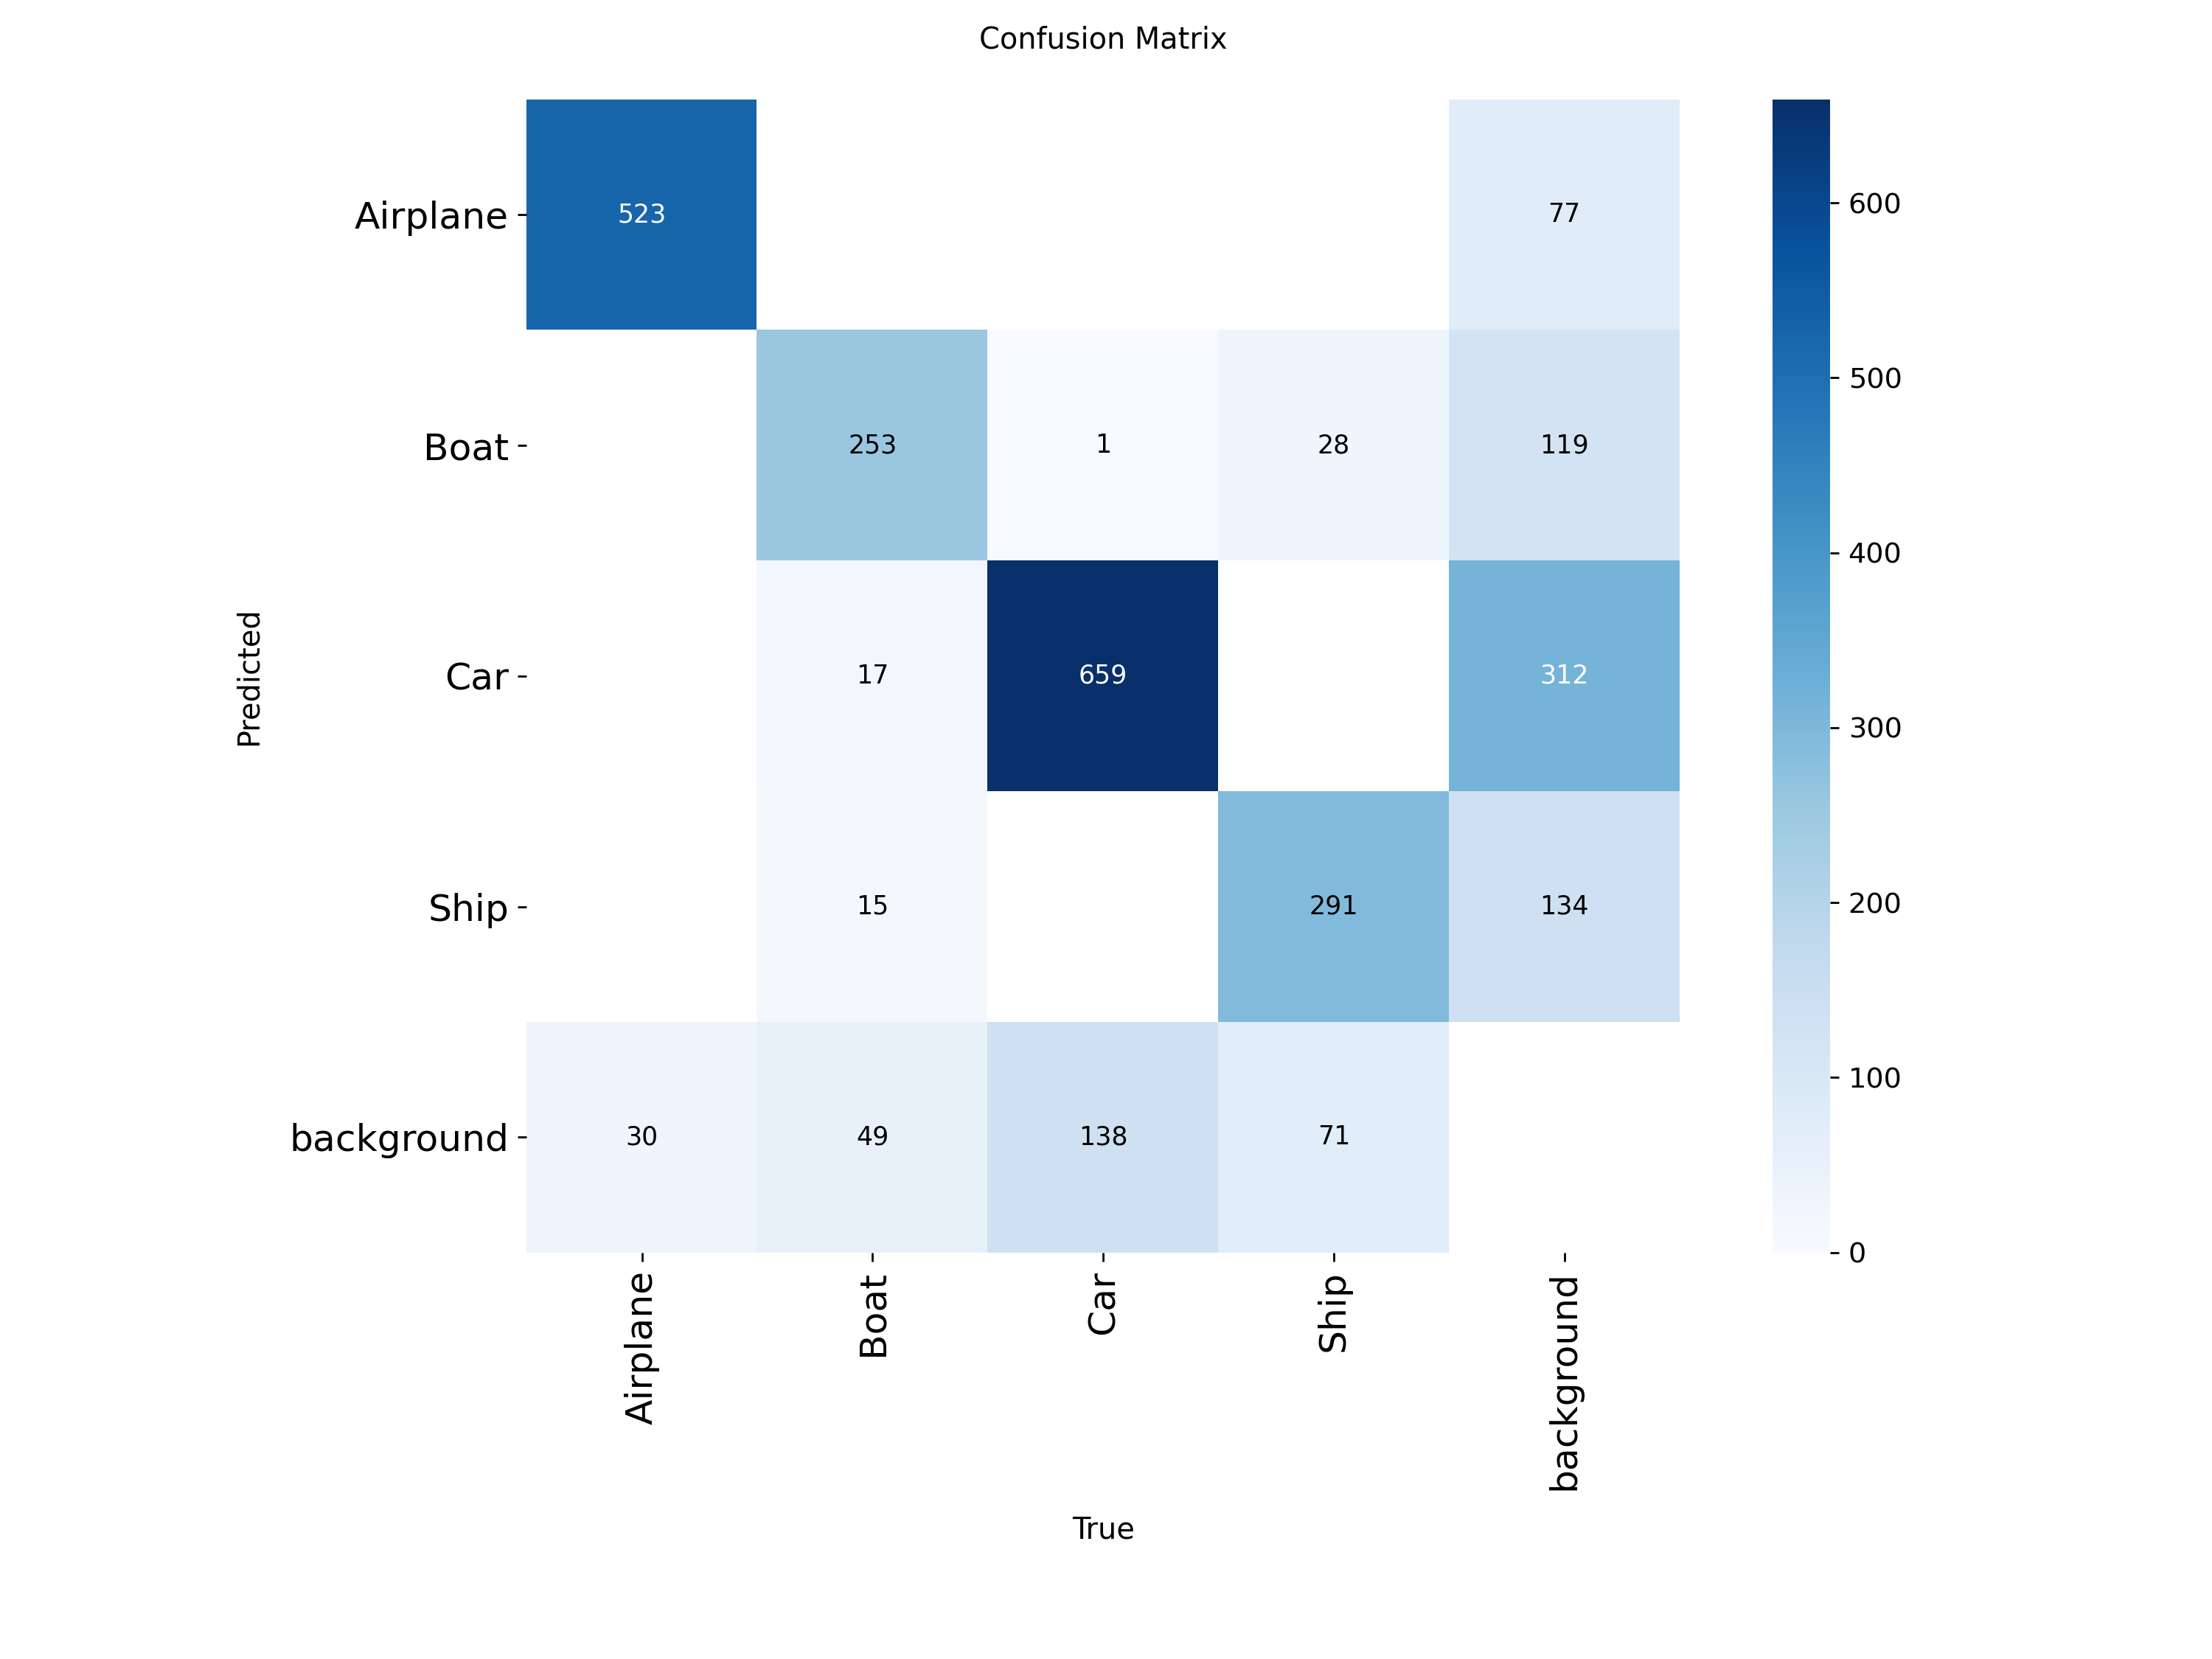

In [28]:
from PIL import Image
from IPython.display import display
from pathlib import Path

# Path to the actual YOLO output
results_img = Path("/kaggle/working/yolo-output/test_evaluation/confusion_matrix.png")

# Check if file exists before opening
if results_img.exists():
    img = Image.open(results_img)
    display(img)
else:
    print("❌ File not found:", results_img)


Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


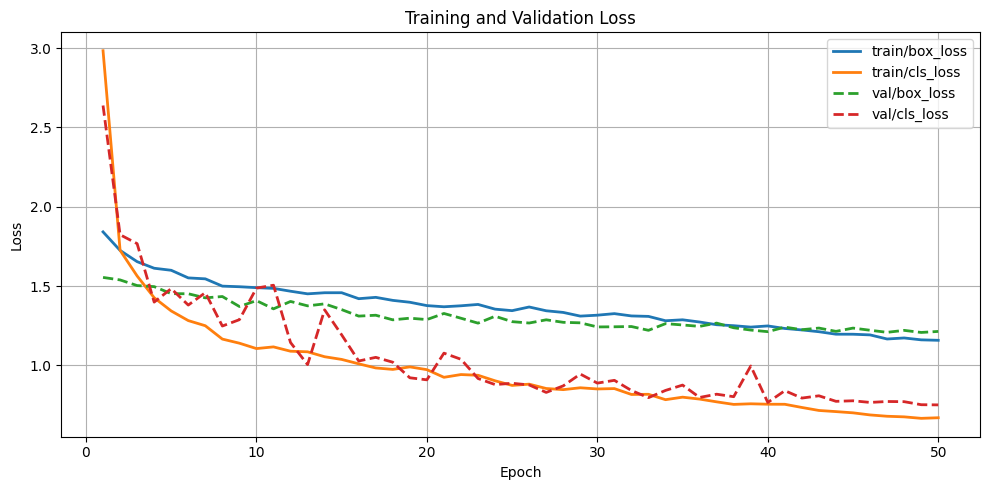

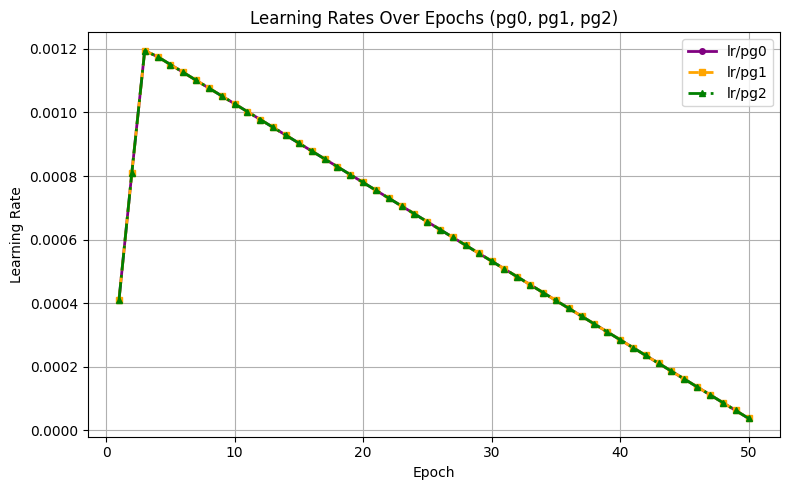

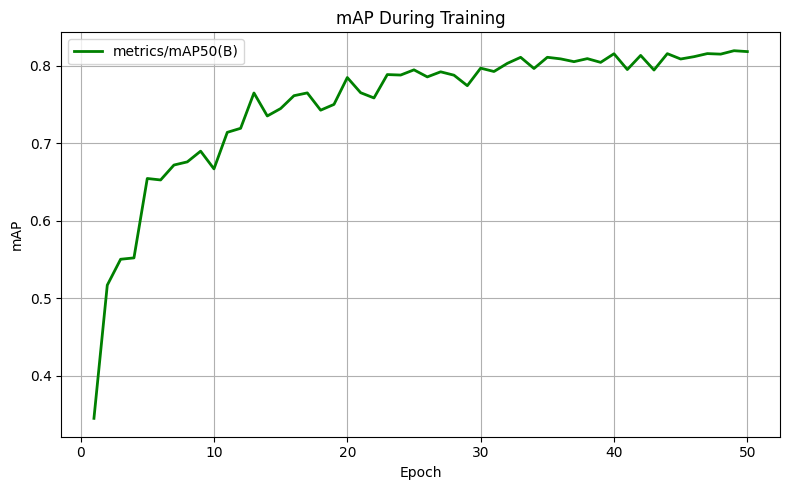

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Set path to results.csv ---
results_path = Path("/kaggle/working/yolo-output/train/results.csv")  # update if needed
if not results_path.exists():
    raise FileNotFoundError(f"CSV file not found at: {results_path}")

# --- Load CSV ---
df = pd.read_csv(results_path)
print("Available columns:", df.columns.tolist())

# =========================
# 1️⃣ Loss Curves
# =========================
plt.figure(figsize=(10,5))
for col in ["train/box_loss", "train/cls_loss", "val/box_loss", "val/cls_loss"]:
    if col in df.columns:
        style = '-' if "train" in col else '--'
        plt.plot(df["epoch"], df[col], label=col, linestyle=style, linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 2️⃣ Learning Rate Curves
# =========================
lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
if lr_columns:
    colors = ['purple', 'orange', 'green']
    styles = ['-', '--', '-.']
    markers = ['o', 's', '^']
    plt.figure(figsize=(8,5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")

# =========================
# 3️⃣ mAP Curve
# =========================
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)", "metrics/mAP50", "metrics/mAP50-95"]  # try common names
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(8,5))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


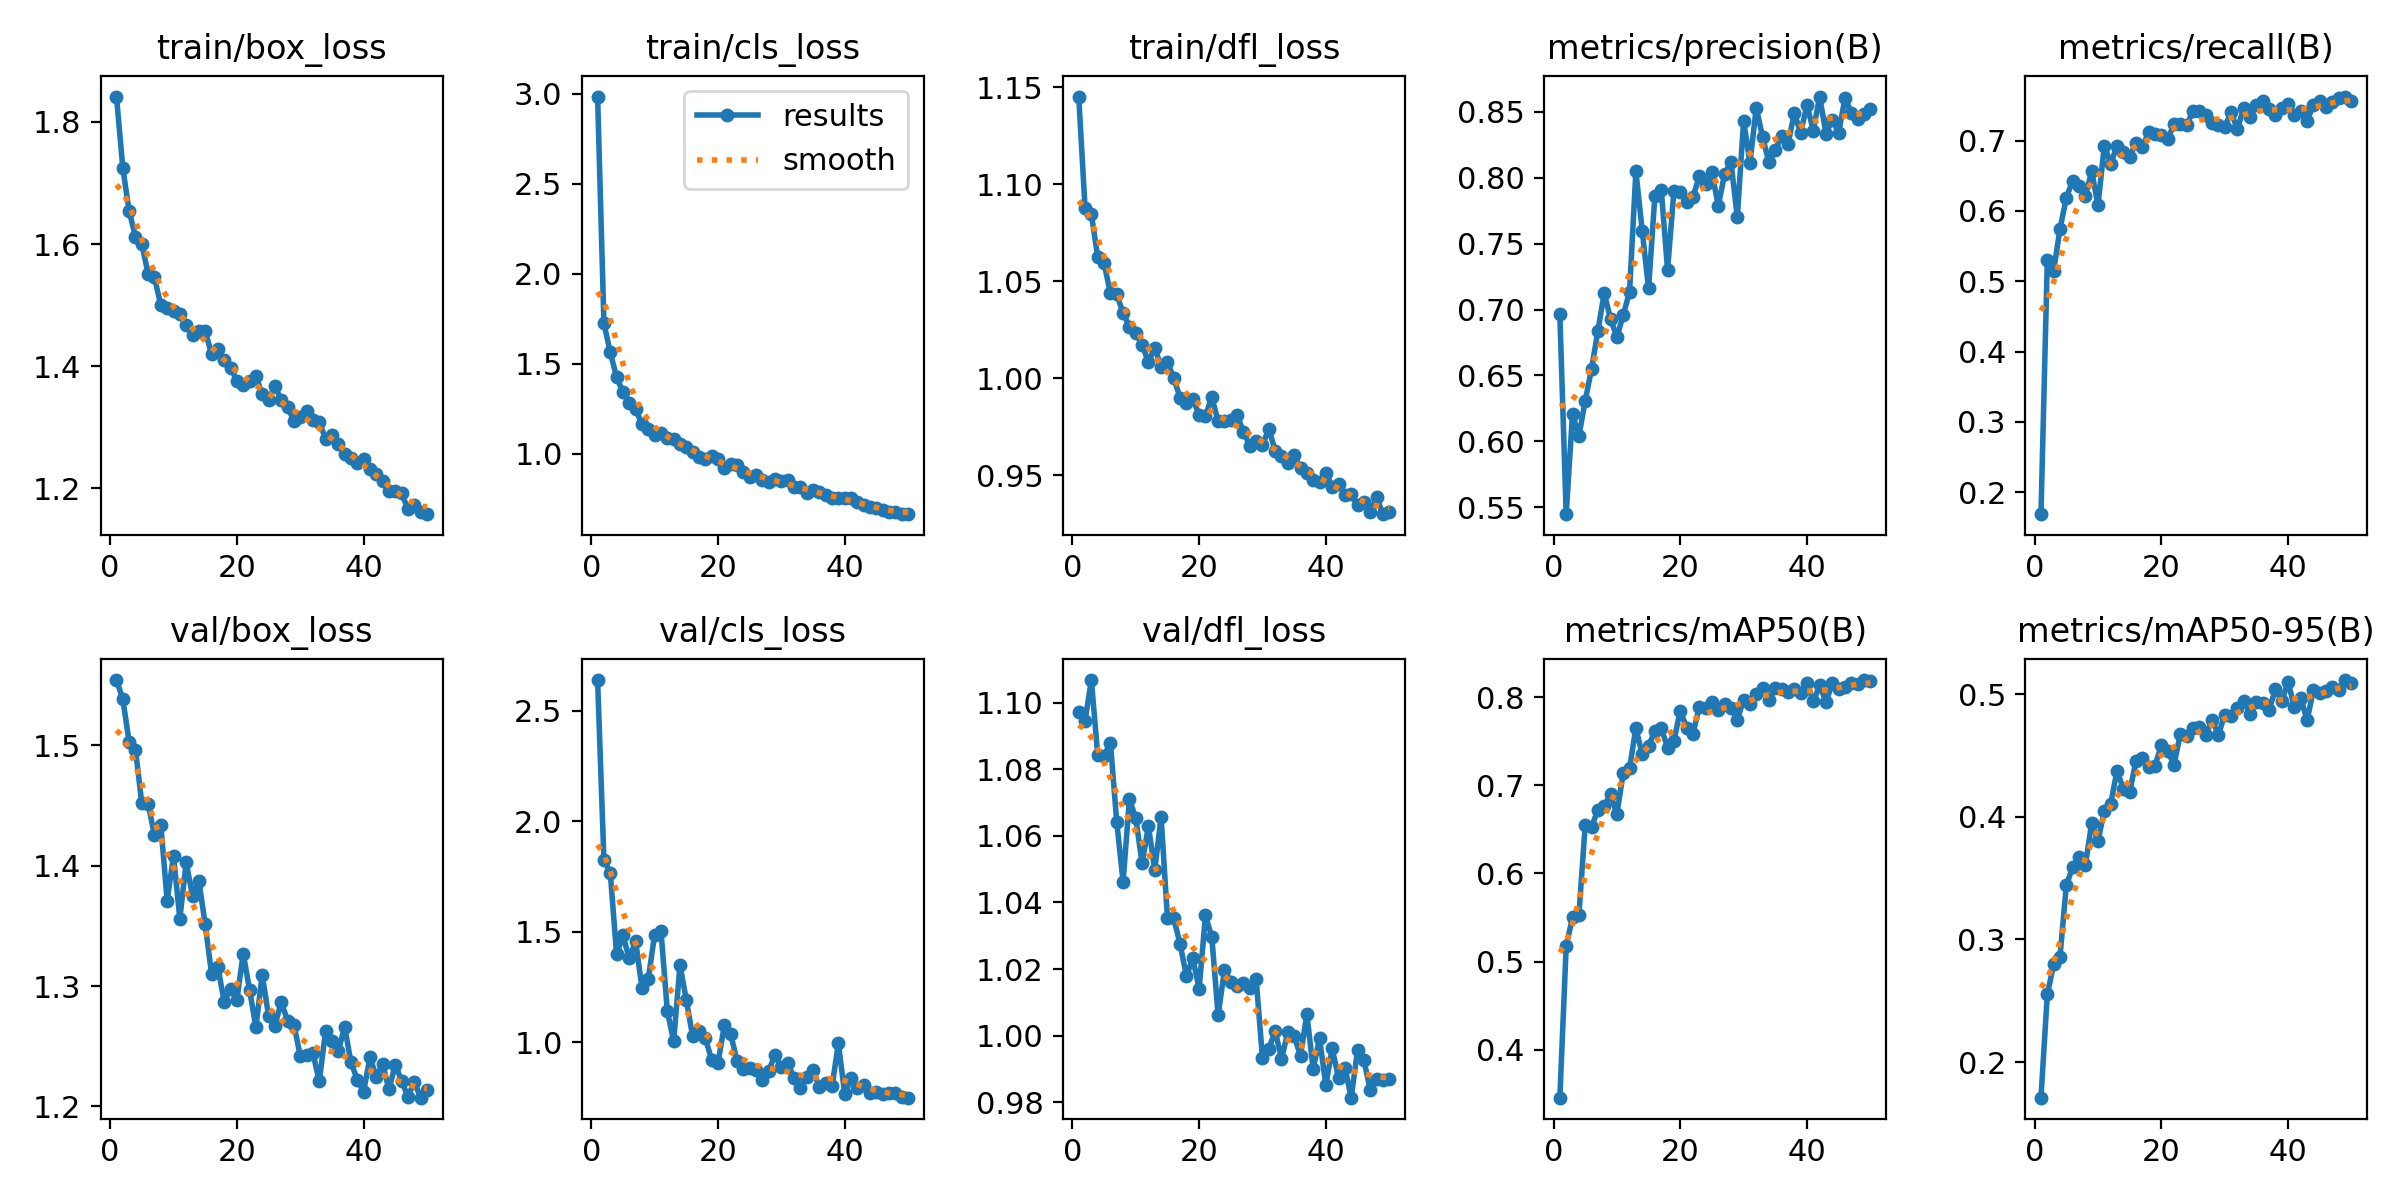

In [30]:
from PIL import Image
from IPython.display import display
from pathlib import Path

# Correct path to results.png
results_img = Path("/kaggle/working/yolo-output/train/results.png")

# Check if file exists
if results_img.exists():
    img = Image.open(results_img)
    display(img)
else:
    print("❌ File not found:", results_img)


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2911.3±1258.4 MB/s, size: 161.1 KB)
val: Scanning /kaggle/working/Skysealand-2/test/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 127/127 271.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 17.0it/s 1.9s0.0s


invalid value encountered in less
invalid value encountered in less


                   all        127       2075      0.843      0.753      0.831      0.495
              Airplane         52        553      0.948      0.915      0.949      0.537
                  Boat         23        334      0.751       0.71      0.775      0.474
                   Car         24        798      0.839      0.741      0.831      0.506
                  Ship         46        390      0.832      0.649      0.769      0.464
Speed: 0.7ms preprocess, 7.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2

Validation metrics
 Precision (mP) : 0.8427
 Recall    (mR) : 0.7535
 mAP@0.50      : 0.8312
 mAP@0.50-0.95 : 0.4953


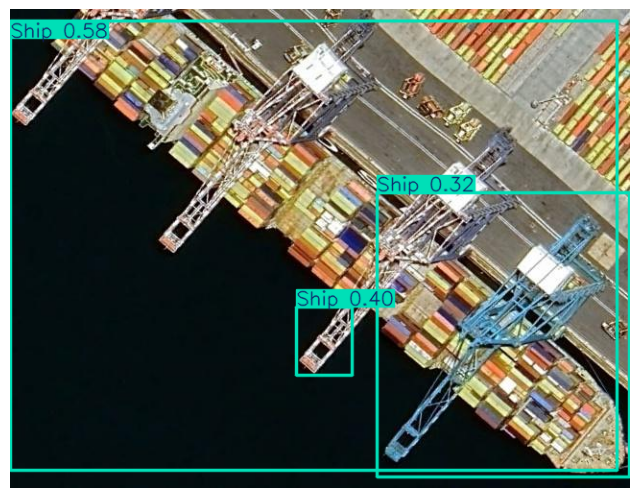

In [31]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- 1️⃣ Paths ---
DATA = "/kaggle/working/Skysealand-2/data.yaml"
WORK3 = Path("/kaggle/working/Skysealand-2")  # test images path
BEST_WEIGHTS_PATH = Path("/kaggle/working/yolo-output/train/weights/best.pt")

# --- 2️⃣ Load YOLO model ---
if not BEST_WEIGHTS_PATH.exists():
    raise FileNotFoundError(f"YOLO weights not found at: {BEST_WEIGHTS_PATH}")

model_det = YOLO(str(BEST_WEIGHTS_PATH))

# --- 3️⃣ Run validation on the test set ---
results = model_det.val(
    data=str(DATA),
    split="test",       # evaluate on test split
    imgsz=640,
    batch=4,
    device=0 if torch.cuda.is_available() else "cpu"
)

# --- 4️⃣ Extract metrics ---
try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# --- 5️⃣ Visualize a random test image ---
test_imgs = list((WORK3/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(
        source=str(img_path),
        imgsz=640,
        conf=0.25,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )[0]

    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR -> RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")


**Semi-supervised**

In [33]:
from pathlib import Path
from ultralytics import YOLO

# Base working directory for SkySeaLand semi-supervised experiments
WORK_DIR = Path("/kaggle/working/skysealand_ssl")
WORK_DIR.mkdir(parents=True, exist_ok=True)

# Labeled YAML path (your SkySeaLand dataset)
SSL_LABELED_YAML = Path("/kaggle/working/Skysealand-2/data.yaml")

# Teacher project & name
ssl_labeled_project = WORK_DIR / "skysealand_yolov12_ssl_labeled"
ssl_labeled_name = "yolov12s_skysea_ssl_labeled"

# Training parameters
SSL_LABELED_EPOCHS = 50   # adjust if needed
BATCH_SIZE = 16
IMAGE_SIZE = 640
PATIENCE = 10


In [35]:
from pathlib import Path
from ultralytics import YOLO
import torch

# Base working directory for SkySeaLand semi-supervised experiments
WORK_DIR = Path("/kaggle/working/skysealand_ssl")
WORK_DIR.mkdir(parents=True, exist_ok=True)

# Labeled YAML path for SkySeaLand dataset
SSL_LABELED_YAML = Path("/kaggle/working/Skysealand-2/data.yaml")
assert SSL_LABELED_YAML.exists(), f"data.yaml not found at {SSL_LABELED_YAML}"

# Teacher project & run name
ssl_labeled_project = WORK_DIR / "skysealand_yolov12_ssl_labeled"
ssl_labeled_name = "yolov12_skysea_ssl_labeled"

# Training parameters
SSL_LABELED_EPOCHS = 50   # adjust if needed
BATCH_SIZE = 16
IMAGE_SIZE = 640
PATIENCE = 10
DEVICE = 0 if torch.cuda.is_available() else "cpu"


In [ ]:
from pathlib import Path
from ultralytics import YOLO
import torch
import os

# Base working directory for semi-supervised experiments
WORK_DIR = Path("/kaggle/working/skysealand_ssl")
WORK_DIR.mkdir(parents=True, exist_ok=True)

# SkySeaLand labeled dataset YAML
DATA_YAML = Path("/kaggle/working/Skysealand-2/data.yaml")
assert DATA_YAML.exists(), f"data.yaml not found at {DATA_YAML}"

# Unlabeled images folder (if you have separate unlabeled data)
UNLABELED_DIR = Path("/kaggle/working/Skysealand-2/unlabeled")


In [ ]:
# Teacher project folder
TEACHER_PROJECT = WORK_DIR / "teacher_yolov8"
TEACHER_NAME = "teacher_skysealand"

# Training params
EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = 640
DEVICE = 0 if torch.cuda.is_available() else "cpu"

# Initialize teacher model (YOLOv8-small/nano)
teacher_model = YOLO("yolov8n.pt")  # or "yolov12n.pt" for YOLOv12

# Train teacher on labeled subset only
teacher_model.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    project=str(TEACHER_PROJECT),
    name=TEACHER_NAME,
    device=DEVICE,
    workers=2,
    exist_ok=True,
)

# Best weights path
TEACHER_WEIGHTS = TEACHER_PROJECT / TEACHER_NAME / "weights" / "best.pt"
print("Teacher weights saved at:", TEACHER_WEIGHTS)


In [ ]:
from pathlib import Path

# Base dataset & pseudo-label paths
SSL_ROOT = Path("/kaggle/working/skysealand_ssl")
UNLABELED_IMG_DIR = SSL_ROOT / "unlabeled"  # Folder with unlabeled images
PSEUDO_LABEL_DIR = SSL_ROOT / "train_unlabeled" / "labels"
PSEUDO_LABEL_DIR.mkdir(parents=True, exist_ok=True)

# Teacher model already trained on labeled data
# teacher_detector = YOLO(str(TEACHER_WEIGHTS))  # ensure this is loaded

# Tighter thresholds for pseudo-labeling
CONF_THRESHOLD = 0.80  # confidence threshold
IOU_THRESHOLD  = 0.60  # NMS IoU threshold

# Collect all unlabeled images
unlabeled_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    unlabeled_imgs.extend(list(UNLABELED_IMG_DIR.glob(ext)))
print("Unlabeled images found:", len(unlabeled_imgs))

# Generate pseudo-labels
for img_path in unlabeled_imgs:
    results = teacher_detector.predict(
        source=str(img_path),
        conf=CONF_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )
    r = results[0]
    boxes = r.boxes

    # Save YOLO-format labels
    lbl_path = PSEUDO_LABEL_DIR / (img_path.stem + ".txt")
    with open(lbl_path, "w") as f:
        if boxes is not None and boxes.xywhn is not None:
            xywhn = boxes.xywhn.cpu().numpy()
            cls = boxes.cls.cpu().numpy().astype(int)
            for (cx, cy, w, h), c in zip(xywhn, cls):
                f.write(f"{c} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

print("✅ Pseudo-labels generated at:", PSEUDO_LABEL_DIR)


In [ ]:
# ============================================================
# 🔹 Pseudo-Label Generation (Semi-Supervised YOLO)
# ============================================================

from pathlib import Path

# --- Paths ---
SSL_ROOT = Path("/kaggle/working/skysealand_ssl")
UNLABELED_IMG_DIR = SSL_ROOT / "unlabeled"  # Folder with unlabeled images
PSEUDO_LABEL_DIR = SSL_ROOT / "train_unlabeled" / "labels"
PSEUDO_LABEL_DIR.mkdir(parents=True, exist_ok=True)

# --- Tighter thresholds for pseudo-labeling ---
CONF_THRESHOLD = 0.80  # confidence threshold
IOU_THRESHOLD  = 0.60  # NMS IoU threshold

# --- Collect all unlabeled images ---
unlabeled_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    unlabeled_imgs.extend(list(UNLABELED_IMG_DIR.glob(ext)))

print(f"Unlabeled images found: {len(unlabeled_imgs)}")

if len(unlabeled_imgs) == 0:
    print("⚠️  No unlabeled images found in:", UNLABELED_IMG_DIR)
else:
    # --- Generate pseudo-labels ---
    for img_path in unlabeled_imgs:
        results = teacher_detector.predict(
            source=str(img_path),
            conf=CONF_THRESHOLD,
            iou=IOU_THRESHOLD,
            verbose=False
        )
        r = results[0]
        boxes = r.boxes

        # Save YOLO-format labels
        lbl_path = PSEUDO_LABEL_DIR / (img_path.stem + ".txt")
        with open(lbl_path, "w") as f:
            if boxes is not None and boxes.xywhn is not None:
                xywhn = boxes.xywhn.cpu().numpy()
                cls = boxes.cls.cpu().numpy().astype(int)
                for (cx, cy, w, h), c in zip(xywhn, cls):
                    f.write(f"{c} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

    print("✅ Pseudo-labels generated at:", PSEUDO_LABEL_DIR)
